In [2]:
import tensorflow as tf
import math
import numpy as np 

In [3]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(x,*args , **kwargs):
        return x

In [4]:
data = np.load('data_with_labels.npz')
train= data['arr_0']/255.
labels = data['arr_1']

print(train[0])
print(labels[0])

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
0


In [5]:
import matplotlib.pyplot as plt
plt.ion()

In [6]:
def to_onehot(labels, nclasses = 5):
    '''
    Convert labels to "one-hot" format.
    >>> a = [0,1,2,3]
    >>> to_onehot(a,5)
    array([[1., 0., 0., 0., 0.],
           [0., 1., 0., 0., 0.],
           [0., 0., 1., 0., 0.],
           [0., 0., 0., 1. 0.]])
    '''
    outlabels = np.zeros((len(labels), nclasses))
    for i, l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)

print(onehot)

[[ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 ..., 
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]]


In [7]:
# Split data into training and validation

indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt], indices[valid_cnt:]
test, train = train[test_idx, :], train[training_idx, :]
onehot_test, onehot_train = onehot[test_idx, :], onehot[training_idx, :]


In [8]:
sess = tf.InteractiveSession()

In [9]:

# These will be inputs
## Input pixes, flattened
x = tf.placeholder("float", [None, 36,36])
x_im = tf.reshape(x,[-1,36,36,1])

## Known labels
y_ = tf.placeholder("float", [None, 5])

In [10]:
# Con Layer 1 
num_filters1 = 16 
winx=3
winy=3


In [11]:
W1 = tf.Variable(tf.truncated_normal([winx,winy,1,num_filters1],stddev=1./math.sqrt(winx*winy)))
b1 = tf.Variable(tf.constant(0.1, shape=[num_filters1]))

xw = tf.nn.conv2d(x_im,W1,strides=[1,1,1,1],padding='SAME')
h1 = tf.nn.relu(xw+b1)
p1 = tf.nn.max_pool(h1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')


In [12]:
# conv layer 2 
num_filters2 = 4
winx2= 3
winy2= 3


In [13]:
W2 = tf.Variable(tf.truncated_normal([winx2,winy2,num_filters1, num_filters2],stddev=1./math.sqrt(winx2*winy2)))
b2 = tf.Variable(tf.constant(0.1,shape=[num_filters2]))

p1w2 = tf.nn.conv2d(p1,W2,strides=[1,1,1,1],padding='SAME')
h1 = tf.nn.relu(p1w2+b2)
p2 = tf.nn.max_pool(h1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')



In [14]:
p2_size = np.product([s.value for s in p2.get_shape()[1:]])
p2f = tf.reshape(p2, [-1,p2_size])


In [15]:
#dense layer 
num_hidden =32
W3 = tf.Variable(tf.truncated_normal([p2_size,num_hidden],stddev=2./math.sqrt(p2_size)))
b3 = tf.Variable(tf.constant(0.2,shape=[num_hidden]))
h3 = tf.nn.relu(tf.matmul(p2f,W3)+b3)

In [16]:
keep_prob = tf.placeholder("float")
h3_drop = tf.nn.dropout(h3,keep_prob)

In [17]:
#output 
W4 = tf.Variable(tf.truncated_normal([num_hidden,5],stddev=1./math.sqrt(num_hidden)))
b4 = tf.Variable(tf.constant(0.1,shape=[5]))


In [18]:
sess.run(tf.initialize_all_variables())
y = tf.nn.softmax(tf.matmul(h3_drop,W4) + b4)

In [19]:
cross_entropy  = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y + 1e-50 ,y_))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

In [21]:
correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))

In [22]:
epochs = 6000 
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs// 10)

for i in tqdm(range(epochs), ascii=True):
    if i % 10 == 0 :
        A = accuracy.eval(feed_dict={x :train, y_: onehot_train,keep_prob:1.0})
        train_acc[i//10] = A
        A = accuracy.eval(feed_dict={x:test,y_:onehot_test, keep_prob:1.0})
        test_acc[i//10] = A
    train_step.run(feed_dict={x:train,y_:onehot_train,keep_prob:0.5})

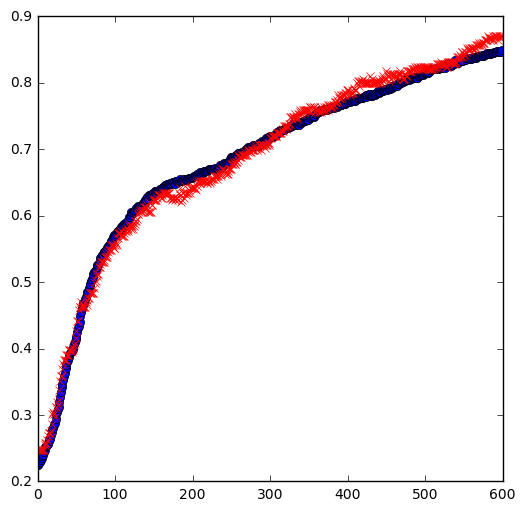

In [23]:
plt.figure(figsize=(6,6))
plt.plot(train_acc,'bo')
plt.plot(test_acc,'rx')


In [25]:
pred = np.argmax(y.eval(feed_dict={x:test,keep_prob:1.0,y_:onehot_test}),axis=1)
conf = np.zeros([5,5])
for p,t in zip(pred,np.argmax(onehot_test,axis=1)):
    conf[t,p] += 1   

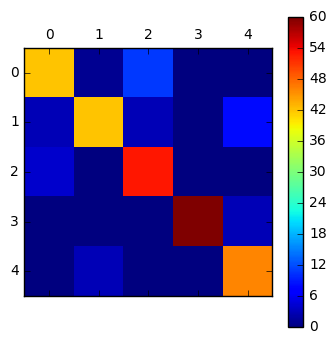

In [26]:
plt.matshow(conf)
plt.colorbar()

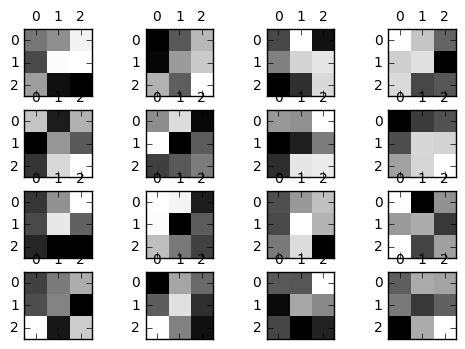

In [28]:
f, plts = plt.subplots(4,4)
for i in range(16):
    plts[i//4,i%4].matshow(W1.eval()[:,:,0,i],cmap = plt.cm.gray_r)

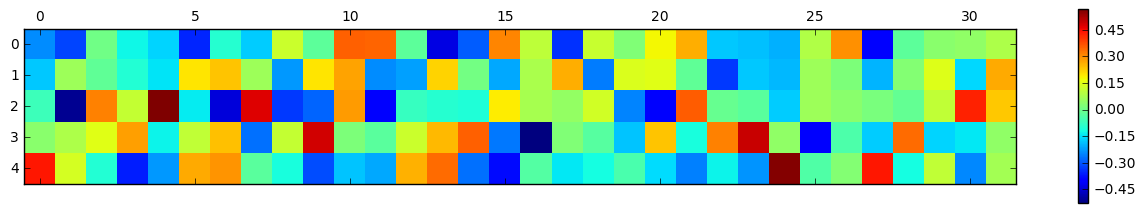

In [29]:
plt.matshow(W4.eval().T)
plt.colorbar()

In [30]:
#save the weights 
saver = tf.train.Saver()
saver.save(sess,"conv1.ckpt")

#restore 

saver.restore(sess,"conv1.ckpt")